In [1]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
output_dir ='/ihme/costeffectiveness/results/vivarium_ciff_sam/v6.0.0_vicious_cycle/ciff_sam/2022_02_17_15_25_21/count_data/'
output_dir_533 ='/ihme/costeffectiveness/results/vivarium_ciff_sam/v5.3.3_sam_k_sensitivity/ciff_sam/2022_02_08_09_51_56/count_data/'

In [3]:
pd.read_csv(output_dir + 'wasting_transition_count.csv')#.age.unique()

,Unnamed: 0,sex,year,measure,input_draw,scenario,value,diarrhea,x_factor,sq_lns,mam_treatment,sam_treatment,age
0,0,female,2022,mild_child_wasting_to_moderate_acute_malnutrit...,29,baseline,0.0,cat2,cat2,covered,covered,covered,early_neonatal
1,1,female,2022,mild_child_wasting_to_moderate_acute_malnutrit...,29,baseline,0.0,cat1,cat2,covered,covered,covered,early_neonatal
2,2,female,2022,mild_child_wasting_to_moderate_acute_malnutrit...,29,baseline,0.0,cat2,cat1,covered,covered,covered,early_neonatal
3,3,female,2022,mild_child_wasting_to_moderate_acute_malnutrit...,29,baseline,0.0,cat1,cat1,covered,covered,covered,early_neonatal
4,4,female,2022,mild_child_wasting_to_moderate_acute_malnutrit...,29,baseline,0.0,cat2,cat2,covered,uncovered,covered,early_neonatal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
645115,645115,male,2026,susceptible_to_child_wasting_to_mild_child_was...,946,wasting_treatment,535.0,cat1,cat1,uncovered,covered,uncovered,2_to_4
645116,645116,male,2026,susceptible_to_child_wasting_to_mild_child_was...,946,wasting_treatment,3615.0,cat2,cat2,uncovered,uncovered,uncovered,2_to_4
645117,645117,male,2026,susceptible_to_child_wasting_to_mild_child_was...,946,wasting_treatment,239.0,cat1,cat2,uncovered,uncovered,uncovered,2_to_4
645118,645118,male,2026,susceptible_to_child_wasting_to_mild_child_was...,946,wasting_treatment,3286.0,cat2,cat1,uncovered,uncovered,uncovered,2_to_4


In [4]:
def calculate_wasting_values(output_dir, ages, strata_cols, measure, metric, 
                             relative_scenario):
    if measure=='prevalence':
        data6 = pd.read_csv(output_dir + 'wasting_state_person_time.csv').drop(columns=['Unnamed: 0'])
        data6['model'] = '6'
        data5 = pd.read_csv(output_dir_533 + 'wasting_state_person_time.csv').drop(columns=['Unnamed: 0'])
        data5['model'] = '5'
        data = pd.concat([data6,data5.loc[data5.sam_k=='alternative']])
        data = data.loc[data.year!=2022]
        wasted = data.loc[data.cause.str.contains('acute_malnutrition')]
        wasted['cause'] = 'wasted'
        wasted = (wasted.groupby([c for c in wasted.columns if c != 'value']).sum())
        data = pd.concat([data,wasted.reset_index()],ignore_index=True)
    elif measure=='incidence':
        data6 = (pd.read_csv(output_dir + 'wasting_transition_count.csv')
                .drop(columns=['Unnamed: 0']).rename(columns={'measure':'cause'}))
        data5 = (pd.read_csv(output_dir_533 + 'wasting_transition_count.csv')
                .drop(columns=['Unnamed: 0']).rename(columns={'measure':'cause'}))
        data6['model'] = '6'
        data5['model'] = '5'
        data = pd.concat([data6,data5.loc[data5.sam_k=='alternative']])
        data = data.loc[data.year!=2022]
        wasted = data.loc[data.cause.isin(['mild_child_wasting_to_moderate_acute_malnutrition_event_count',
                                          'moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count'])]
        wasted['cause'] = 'wasted'
        total_mam = data.loc[data.cause.isin(['mild_child_wasting_to_moderate_acute_malnutrition_event_count',
                                             'severe_acute_malnutrition_to_moderate_acute_malnutrition_event_count'])]
        total_mam['cause'] = 'total_mam'
        wasted = pd.concat([wasted,total_mam])
        wasted = (wasted.groupby([c for c in wasted.columns if c != 'value']).sum())
        data = pd.concat([data,wasted.reset_index()],ignore_index=True)
        pt = pd.read_csv(output_dir + 'wasting_state_person_time.csv').drop(columns=['Unnamed: 0'])
        pt = pt.loc[pt.year!=2022]
    groupby_cols = ['input_draw','scenario','cause']
    data = data.loc[data.age.isin(ages)]    
    if 'year' in strata_cols:
        t = data.loc[(data.year==2023)&(data.scenario=='baseline')]
        t['year'] = 2022
        for i in data.scenario.unique():
            t['scenario'] = i
            data = pd.concat([data,t])   
        if measure=='incidence':
            t = pt.loc[(pt.year==2023)&(pt.scenario=='baseline')]
            t['year'] = 2022
            for i in data.scenario.unique():
                t['scenario'] = i
                pt = pd.concat([pt,t])
    data = data.groupby(['input_draw','scenario'] + strata_cols + ['cause']).sum()
    if measure=='prevalence':
        data = data / data.groupby(['input_draw','scenario'] + strata_cols).sum() * 100
    else:
        pt = pt.loc[pt.age.isin(ages)].groupby(['input_draw','scenario'] + strata_cols).sum()
        data = data / pt * 100_000     
    if metric=='value':
        data = (data.groupby(['scenario','cause'] + strata_cols)
                    .describe(percentiles=[0.025,0.975]))
    else:
        data_baseline = (data.reset_index().loc[data.reset_index().scenario==relative_scenario]
                   .set_index(['input_draw','cause'] + strata_cols)
                   .drop(columns='scenario'))
        if metric=='percent_reduction':
            data = ((data_baseline - data.reset_index().set_index(['input_draw','cause'] + strata_cols + ['scenario']))
                    / data_baseline) * 100
        elif metric=='absolute_reduction':
            data = data_baseline - data.reset_index().set_index(['input_draw','cause'] + strata_cols + ['scenario'])
            
        data = (data.reset_index().groupby(['scenario','cause'] + strata_cols)
                .describe(percentiles=[0.025,0.975])).drop(columns='input_draw')
    return data[['value']].reset_index()

In [5]:
six_to_59_ages = ['6-11_months',
       '12_to_23_months', '2_to_4']
ages = ['6-11_months',
       '12_to_23_months', '2_to_4']

In [6]:
pt = pd.read_csv(output_dir + 'wasting_state_person_time.csv').drop(columns=['Unnamed: 0'])
pt = pt.loc[pt.age.isin(ages)]
pt

,sex,year,cause,measure,input_draw,scenario,value,diarrhea,x_factor,sq_lns,mam_treatment,sam_treatment,age
96,female,2022,mild_child_wasting,state_person_time,29,baseline,0.000000,cat2,cat2,covered,covered,covered,6-11_months
97,female,2022,mild_child_wasting,state_person_time,29,baseline,0.000000,cat1,cat2,covered,covered,covered,6-11_months
98,female,2022,mild_child_wasting,state_person_time,29,baseline,0.000000,cat2,cat1,covered,covered,covered,6-11_months
99,female,2022,mild_child_wasting,state_person_time,29,baseline,0.000000,cat1,cat1,covered,covered,covered,6-11_months
100,female,2022,mild_child_wasting,state_person_time,29,baseline,0.000000,cat2,cat2,covered,uncovered,covered,6-11_months
...,...,...,...,...,...,...,...,...,...,...,...,...,...
368635,male,2026,susceptible_to_child_wasting,state_person_time,946,wasting_treatment,37.368925,cat1,cat1,uncovered,covered,uncovered,2_to_4
368636,male,2026,susceptible_to_child_wasting,state_person_time,946,wasting_treatment,1062.683094,cat2,cat2,uncovered,uncovered,uncovered,2_to_4
368637,male,2026,susceptible_to_child_wasting,state_person_time,946,wasting_treatment,17.493498,cat1,cat2,uncovered,uncovered,uncovered,2_to_4
368638,male,2026,susceptible_to_child_wasting,state_person_time,946,wasting_treatment,970.992471,cat2,cat1,uncovered,uncovered,uncovered,2_to_4


In [14]:
pt = pd.read_csv(output_dir + 'wasting_state_person_time.csv').drop(columns=['Unnamed: 0'])
pt = pt.loc[pt.age.isin(ages)]

trans = pd.read_csv(output_dir + 'wasting_transition_count.csv').drop(columns=['Unnamed: 0'])
trans = trans.loc[trans.age.isin(ages)]
trans['cause'] = (trans.measure
                  .str.replace('susceptible_to_child_wasting','tmrel')
                  .str.split('_to_',expand=True)[1]
                  .str.split('_event_count',expand=True)[0]
                  .str.replace('tmrel','susceptible_to_child_wasting'))
cols = ['input_draw','scenario','cause','year']
data = (pt.groupby(cols).sum() / trans.groupby(cols).sum() * 365).reset_index()
data = data.loc[data.year==2026].groupby(['cause','scenario']).describe(percentiles=[0.025,0.975])['value']
data

count        mean  \
cause                        scenario                                 
mild_child_wasting           baseline              12.0   25.129943   
                             lbwsg_interventions   12.0   25.668221   
                             sqlns                 12.0   25.669023   
                             wasting_treatment     12.0   25.084853   
moderate_acute_malnutrition  baseline              12.0   54.672420   
                             lbwsg_interventions   12.0   46.592252   
                             sqlns                 12.0   46.593371   
                             wasting_treatment     12.0   46.195356   
severe_acute_malnutrition    baseline              12.0  480.047425   
                             lbwsg_interventions   12.0  464.180326   
                             sqlns                 12.0  463.828013   
                             wasting_treatment     12.0  410.768564   
susceptible_to_child_wasting baseline              12.0   96.126264   
                             lbwsg_interventions   12.0   96.082975   
                             sqlns                 12.0   96.091739   
                             wasting_treatment     12.0   96.014791   

                                                         std         min  \
cause                        scenario                                      
mild_child_wasting           baseline               0.375981   24.738704   
                             lbwsg_interventions    0.370869   25.313175   
                             sqlns                  0.371255   25.312951   
                             wasting_treatment      0.362809   24.702973   
moderate_acute_malnutrition  baseline               4.510486   51.186849   
                             lbwsg_interventions    4.556044   43.528263   
                             sqlns                  4.549776   43.528585   
                             wasting_treatment      3.857175   43.592291   
severe_acute_malnutrition    baseline             166.678962  279.182984   
                             lbwsg_interventions  154.892147  257.336753   
                             sqlns                154.658868  257.210724   
                             wasting_treatment    129.513748  236.588100   
susceptible_to_child_wasting baseline               0.803417   93.900738   
                             lbwsg_interventions    0.747123   94.009671   
                             sqlns                  0.749802   94.011040   
                             wasting_treatment      0.772431   93.884907   

                                                        2.5%         50%  \
cause                        scenario                                      
mild_child_wasting           baseline              24.756747   24.963038   
                             lbwsg_interventions   25.314940   25.589760   
                             sqlns                 25.314966   25.589715   
                             wasting_treatment     24.721424   24.920392   
moderate_acute_malnutrition  baseline              51.376924   52.223446   
                             lbwsg_interventions   43.602473   44.329043   
                             sqlns                 43.606604   44.330470   
                             wasting_treatment     43.618360   44.296480   
severe_acute_malnutrition    baseline             291.311711  417.413196   
                             lbwsg_interventions  276.941980  414.588054   
                             sqlns                276.843791  414.642235   
                             wasting_treatment    252.221574  373.591937   
susceptible_to_child_wasting baseline              94.323324   96.302782   
                             lbwsg_interventions   94.410314   96.265062   
                             sqlns                 94.412876   96.275165   
                             wasting_treatment     94.308276   96.185090   

                                 

In [15]:
data = calculate_wasting_values(output_dir, six_to_59_ages, ['model','year'], 
                                        'prevalence', 
                                        'value', 
                                        'baseline')
data

<ipython-input-4-5b0cdbe638e9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasted['cause'] = 'wasted'
<ipython-input-4-5b0cdbe638e9>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['year'] = 2022
<ipython-input-4-5b0cdbe638e9>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

scenario                         cause model  year value  \
                                                                 count   
0             baseline            mild_child_wasting     5  2022  12.0   
1             baseline            mild_child_wasting     5  2023  12.0   
2             baseline            mild_child_wasting     5  2024  12.0   
3             baseline            mild_child_wasting     5  2025  12.0   
4             baseline            mild_child_wasting     5  2026  12.0   
..                 ...                           ...   ...   ...   ...   
155  wasting_treatment  susceptible_to_child_wasting     6  2022  12.0   
156  wasting_treatment  susceptible_to_child_wasting     6  2023  12.0   
157  wasting_treatment  susceptible_to_child_wasting     6  2024  12.0   
158  wasting_treatment  susceptible_to_child_wasting     6  2025  12.0   
159  wasting_treatment  susceptible_to_child_wasting     6  2026  12.0   

                                                                      \
          mean       std        min       2.5%        50%      97.5%   
0    20.730581  0.110521  20.620048  20.631676  20.711308  20.978997   
1    20.730581  0.110521  20.620048  20.631676  20.711308  20.978997   
2    20.724219  0.123611  20.533645  20.562031  20.703067  20.979639   
3    20.714590  0.088473  20.571625  20.581099  20.714616  20.872427   
4    20.716968  0.097401  20.589937  20.600181  20.714207  20.917688   
..         ...       ...        ...        ...        ...        ...   
155  65.632446  1.014994  64.474697  64.523708  65.248433  67.374672   
156  65.887890  0.973005  64.729340  64.793960  65.535082  67.558596   
157  66.748404  0.879473  65.559562  65.663816  66.525442  68.193878   
158  67.577161  0.822574  66.204023  66.407990  67.405027  68.891012   
159  68.019310  0.737807  66.746890  66.919423  67.915660  69.129655   

                
           max  
0    21.058826  
1    21.058826  
2    21.039265  
3    20.906895  
4    20.977790  
..         ...  
155  67.450505  
156  67.627982  
157  68.230548  
158  68.913424  
159  69.148167  

[160 rows x 12 columns]

In [16]:
data.model.unique()

array(['5', '6'], dtype=object)

In [17]:
data.loc[data.model=='6']

scenario                         cause model  year value  \
                                                                 count   
5             baseline            mild_child_wasting     6  2022  12.0   
6             baseline            mild_child_wasting     6  2023  12.0   
7             baseline            mild_child_wasting     6  2024  12.0   
8             baseline            mild_child_wasting     6  2025  12.0   
9             baseline            mild_child_wasting     6  2026  12.0   
..                 ...                           ...   ...   ...   ...   
155  wasting_treatment  susceptible_to_child_wasting     6  2022  12.0   
156  wasting_treatment  susceptible_to_child_wasting     6  2023  12.0   
157  wasting_treatment  susceptible_to_child_wasting     6  2024  12.0   
158  wasting_treatment  susceptible_to_child_wasting     6  2025  12.0   
159  wasting_treatment  susceptible_to_child_wasting     6  2026  12.0   

                                                                      \
          mean       std        min       2.5%        50%      97.5%   
5    20.275782  0.330171  19.807537  19.832086  20.363254  20.784070   
6    20.275782  0.330171  19.807537  19.832086  20.363254  20.784070   
7    20.283994  0.312502  19.851506  19.858998  20.367847  20.767199   
8    20.292179  0.309768  19.807306  19.842030  20.362545  20.752407   
9    20.278908  0.328059  19.822924  19.830371  20.329992  20.801382   
..         ...       ...        ...        ...        ...        ...   
155  65.632446  1.014994  64.474697  64.523708  65.248433  67.374672   
156  65.887890  0.973005  64.729340  64.793960  65.535082  67.558596   
157  66.748404  0.879473  65.559562  65.663816  66.525442  68.193878   
158  67.577161  0.822574  66.204023  66.407990  67.405027  68.891012   
159  68.019310  0.737807  66.746890  66.919423  67.915660  69.129655   

                
           max  
5    20.814787  
6    20.814787  
7    20.781719  
8    20.754368  
9    20.815129  
..         ...  
155  67.450505  
156  67.627982  
157  68.230548  
158  68.913424  
159  69.148167  

[80 rows x 12 columns]

In [24]:
data = calculate_wasting_values(output_dir, six_to_59_ages, ['model','year'], 
                                    'prevalence', 
                                    metric, 
                                    'baseline')
for model in ['5','6']:
    for cause in causes:
        p = data.loc[(data.cause==cause)&(data.model==model)]
        pos = axs[metrics.index(metric),causes.index(cause)]   
        for i in ['baseline','wasting_treatment','sqlns']:
            p_sub = p.loc[p.scenario==i]
p_sub

<ipython-input-4-5b0cdbe638e9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasted['cause'] = 'wasted'
<ipython-input-4-5b0cdbe638e9>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['year'] = 2022
<ipython-input-4-5b0cdbe638e9>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

scenario                      cause model  year value             \
                                                    count       mean   
105    sqlns  severe_acute_malnutrition     6  2022  12.0   0.000000   
106    sqlns  severe_acute_malnutrition     6  2023  12.0   3.425747   
107    sqlns  severe_acute_malnutrition     6  2024  12.0  13.668337   
108    sqlns  severe_acute_malnutrition     6  2025  12.0  23.193733   
109    sqlns  severe_acute_malnutrition     6  2026  12.0  28.780209   

                                                                      
          std        min       2.5%        50%      97.5%        max  
105  0.000000   0.000000   0.000000   0.000000   0.000000   0.000000  
106  0.492143   2.517565   2.612137   3.372591   4.236623   4.282983  
107  1.974493  10.756867  10.867791  13.410781  17.135637  17.617390  
108  3.088724  18.357329  18.453121  22.937756  27.986125  28.440589  
109  3.408297  23.462485  23.542491  28.673014  34.205440  34.748354

In [22]:
cause

'severe_acute_malnutrition'

In [23]:
data.loc[(data.model=='6')&(data.cause==cause)]

scenario                      cause model  year value  \
                                                                count   
25              baseline  severe_acute_malnutrition     6  2022  12.0   
26              baseline  severe_acute_malnutrition     6  2023  12.0   
27              baseline  severe_acute_malnutrition     6  2024  12.0   
28              baseline  severe_acute_malnutrition     6  2025  12.0   
29              baseline  severe_acute_malnutrition     6  2026  12.0   
65   lbwsg_interventions  severe_acute_malnutrition     6  2022  12.0   
66   lbwsg_interventions  severe_acute_malnutrition     6  2023  12.0   
67   lbwsg_interventions  severe_acute_malnutrition     6  2024  12.0   
68   lbwsg_interventions  severe_acute_malnutrition     6  2025  12.0   
69   lbwsg_interventions  severe_acute_malnutrition     6  2026  12.0   
105                sqlns  severe_acute_malnutrition     6  2022  12.0   
106                sqlns  severe_acute_malnutrition     6  2023  12.0   
107                sqlns  severe_acute_malnutrition     6  2024  12.0   
108                sqlns  severe_acute_malnutrition     6  2025  12.0   
109                sqlns  severe_acute_malnutrition     6  2026  12.0   
145    wasting_treatment  severe_acute_malnutrition     6  2022  12.0   
146    wasting_treatment  severe_acute_malnutrition     6  2023  12.0   
147    wasting_treatment  severe_acute_malnutrition     6  2024  12.0   
148    wasting_treatment  severe_acute_malnutrition     6  2025  12.0   
149    wasting_treatment  severe_acute_malnutrition     6  2026  12.0   

                                                                      \
          mean       std        min       2.5%        50%      97.5%   
25    0.000000  0.000000   0.000000   0.000000   0.000000   0.000000   
26    0.000000  0.000000   0.000000   0.000000   0.000000   0.000000   
27    0.000000  0.000000   0.000000   0.000000   0.000000   0.000000   
28    0.000000  0.000000   0.000000   0.000000   0.000000   0.000000   
29    0.000000  0.000000   0.000000   0.000000   0.000000   0.000000   
65    0.000000  0.000000   0.000000   0.000000   0.000000   0.000000   
66    3.424330  0.491957   2.517546   2.610960   3.372519   4.235366   
67   13.648935  1.974718  10.739308  10.851180  13.391854  17.119045   
68   23.155142  3.090972  18.301831  18.404936  22.890864  27.956143   
69   28.711681  3.417343  23.394304  23.478440  28.599996  34.162008   
105   0.000000  0.000000   0.000000   0.000000   0.000000   0.000000   
106   3.425747  0.492143   2.517565   2.612137   3.372591   4.236623   
107  13.668337  1.974493  10.756867  10.867791  13.410781  17.135637   
108  23.193733  3.088724  18.357329  18.453121  22.937756  27.986125   
109  28.780209  3.408297  23.462485  23.542491  28.673014  34.205440   
145   0.000000  0.000000   0.000000   0.000000   0.000000   0.000000   
146   3.245432  0.514763   2.223500   2.351595   3.192223   4.061452   
147  12.813585  2.053772   9.404317   9.708002  12.465383  16.227066   
148  21.731700  3.306245  15.722432  16.236471  21.156294  26.510629   
149  26.931010  3.645479  20.399537  20.915237  26.414931  32.354267   

                
           max  
25    0.000000  
26    0.000000  
27    0.000000  
28    0.000000  
29    0.000000  
65    0.000000  
66    4.282983  
67   17.605590  
68   28.415543  
69   34.711170  
105   0.000000  
106   4.282983  
107  17.617390  
108  28.440589  
109  34.748354  
145   0.000000  
146   4.092998  
147  16.582663  
148  26.806571  
149  32.694718

In [19]:
p

Empty DataFrame
Columns: [(scenario, ), (cause, ), (model, ), (year, ), (value, count), (value, mean), (value, std), (value, min), (value, 2.5%), (value, 50%), (value, 97.5%), (value, max)]
Index: []

## Finding 1: cross sectional prevalence

<ipython-input-4-5b0cdbe638e9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasted['cause'] = 'wasted'
<ipython-input-4-5b0cdbe638e9>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['year'] = 2022
<ipython-input-4-5b0cdbe638e9>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

Text(1.5, 2.7, 'Simulated intervention impacts on acute malnutrition\ncross-sectional exposure among children 24 to 59 months\n(with 95% uncertainty intervals)')

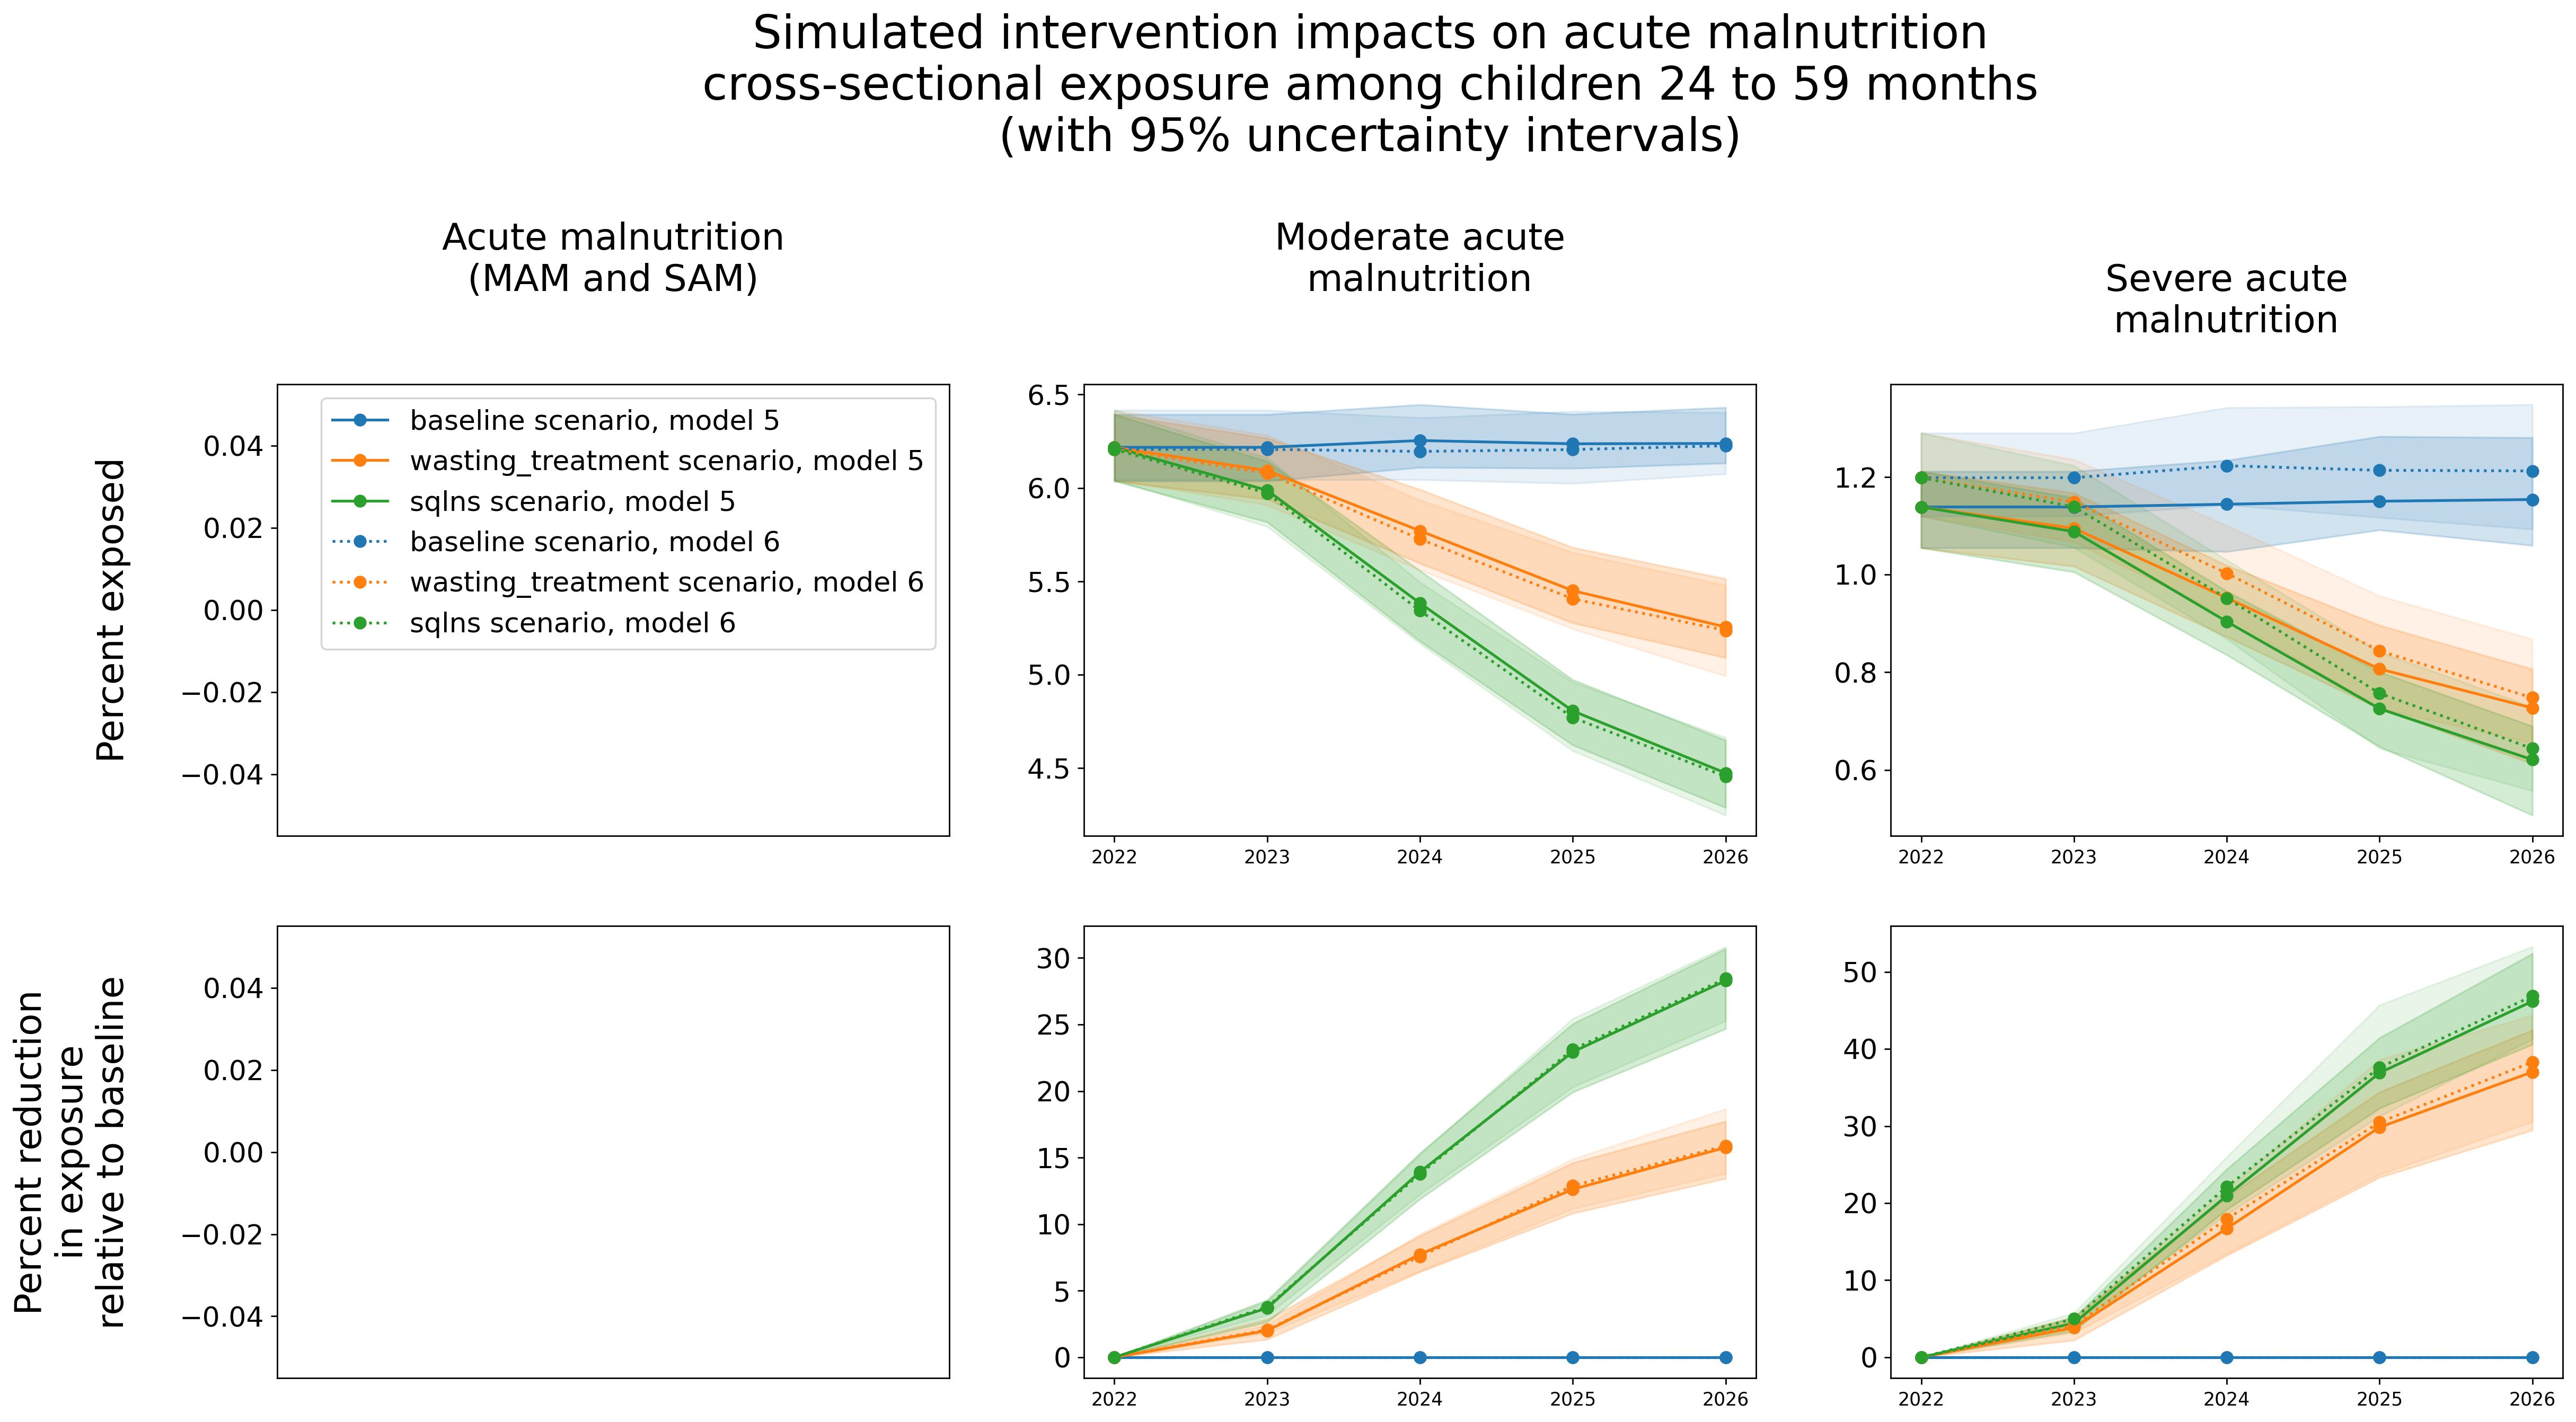

In [28]:
causes = ['wasted','moderate_acute_malnutrition','severe_acute_malnutrition']
cause_titles = ['Acute malnutrition\n(MAM and SAM)\n\n',
               'Moderate acute\nmalnutrition\n\n',
               'Severe acute\nmalnutrition\n']
metrics = ['value','percent_reduction']

fig, axs = plt.subplots(len(metrics), len(causes),dpi=250)
for metric in metrics:
    data = calculate_wasting_values(output_dir, six_to_59_ages, ['model','year','age'], 
                                        'prevalence', 
                                        metric, 
                                        'baseline')
    data = data.loc[data.age=='2_to_4']
    for model in ['5','6']:
        for cause in causes:
            p = data.loc[(data.cause==cause)&(data.model==model)]
            pos = axs[metrics.index(metric),causes.index(cause)]   
            for i in ['baseline','wasting_treatment','sqlns']:
                p_sub = p.loc[p.scenario==i]
                if i =='baseline':
                    color = 'tab:blue'
                elif i == 'wasting_treatment':
                    color='tab:orange'
                else:
                    color='tab:green'
                if model == '5':
                    linestyle='solid'
                    alpha=0.2
                else:
                    linestyle='dotted'
                    alpha=0.1
                pos.plot(p_sub['year'], p_sub['value','mean'], marker='o', label=f'{i} scenario, model {model}',
                        c = color, linestyle=linestyle)
                pos.fill_between(p_sub['year'], p_sub['value','2.5%'], p_sub['value','97.5%'], alpha=alpha, color=color)
            pos.grid()
            pos.set_xticks(p_sub.year.unique())
            #pos.set_xticklabels(p_sub.year.unique(),Fontsize=15)
            pos.tick_params(axis='y', labelsize=15)
            if metrics.index(metric)==0:
                #pos.set_ylim(0,p.loc[p.scenario=='baseline']['value','97.5%'].max()*1.1)
                pos.set_title(cause_titles[causes.index(cause)],size=20)
                if causes.index(cause)==0:
                    pos.set_ylabel('Percent exposed\n',size=20)
                    pos.legend(#['Baseline','Alternative scenario 1','Alternative scenario 2'], 
                           fontsize=15)
            if metric=='percent_reduction':
                #pos.set_ylim(-2,45)
                if causes.index(cause)==0:
                    pos.set_ylabel('Percent reduction\nin exposure\nrelative to baseline\n',size=20)
            pos.grid()
plt.subplots_adjust(right=len(causes), top=len(metrics))
#plt.legend(['Baseline','Alternative scenario 1','Alternative scenario 2'], bbox_to_anchor=[0.25,4.15], fontsize=20)
plt.suptitle('Simulated intervention impacts on acute malnutrition\ncross-sectional exposure among children 24 to 59 months\n(with 95% uncertainty intervals)',
             y=2.7,x=1.5,size=25)


# Finding 2: incidence

In [ ]:
causes = ['mild_child_wasting_to_moderate_acute_malnutrition_event_count',
          'moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count',
          #'total_mam',
          #'moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count'
         ]

cause_titles = ['Moderate acute malnutrition\n',
                'Severe acute malnutrition\n',
                #'All transitions\ninto MAM\n',
                #'MAM cases from\nspontaneous\nSAM recovery'
               ]
metrics = ['value','absolute_reduction','percent_reduction']
metric_titles=['New cases per\n100,000 person-years\n',
              'Reduction in new cases\nper 100,000 person-years\nrelative to baseline\n',
              'Percent reduction\nin annual new cases\nrelative to baseline\n']

fig, axs = plt.subplots(len(metrics), len(causes),dpi=250)
for metric in metrics:
    data = calculate_wasting_values(output_dir, six_to_59_ages, ['sam_k','year'], 
                                        'incidence', 
                                        metric, 
                                  'baseline')
    for k in ['baseline','alternative']:
        for cause in causes:
            p = data.loc[(data.cause==cause)&(data.sam_k==k)]
            pos = axs[metrics.index(metric),causes.index(cause)]   
            for i in ['baseline','wasting_treatment','sqlns']:
                p_sub = p.loc[p.scenario==i]
                if i =='baseline':
                    color = 'tab:blue'
                elif i == 'wasting_treatment':
                    color='tab:orange'
                else:
                    color='tab:green'
                if k == 'baseline':
                    linestyle='solid'
                    alpha=0.2
                else:
                    linestyle='dotted'
                    alpha=0.1
                pos.plot(p_sub['year'], p_sub['value','mean'], marker='o', label=f'{i} scenario, {k} K',
                        c = color, linestyle=linestyle)
                pos.fill_between(p_sub['year'], p_sub['value','2.5%'], p_sub['value','97.5%'], alpha=alpha, color=color)
            pos.grid()
            pos.set_xticks(p_sub.year.unique())
            pos.set_xticklabels(p_sub.year.unique())#,Fontsize=15)
            pos.tick_params(axis='y', labelsize=15)
            if causes.index(cause)==0:
                pos.set_ylabel(metric_titles[metrics.index(metric)],size=20)
                if metrics.index(metric)==0:
                    pos.legend(#['Baseline','Alternative scenario 1','Alternative scenario 2'],
                          #bbox_to_anchor=[0.25,4.15], 
                          # fontsize=15
                    )
            if metrics.index(metric)==0:
                pos.set_title(cause_titles[causes.index(cause)],size=20)
                #pos.set_ylim(0,p.loc[p.scenario=='baseline']['value','97.5%'].max()*1.1)
            
plt.subplots_adjust(right=len(causes), top=len(metrics))
#plt.legend(['Baseline','Alternative scenario 1','Alternative scenario 2'], bbox_to_anchor=[0.25,4.15], fontsize=20)
plt.suptitle('Simulated intervention impacts on acute malnutrition\nincidence rates among children six to 59 months\n(with 95% uncertainty intervals)',
             y=len(metrics)+.5,x=1,size=25)

# Finding 3: relative to alternative scenario 1

In [ ]:
causes = ['wasted','moderate_acute_malnutrition','severe_acute_malnutrition']
cause_titles = ['Acute malnutrition\n(MAM and SAM)\n\n',
               'Moderate acute\nmalnutrition\n\n',
               'Severe acute\nmalnutrition\n']
metrics = ['value','percent_reduction']

fig, axs = plt.subplots(len(metrics), len(causes),dpi=250)
for metric in metrics:
    data = calculate_wasting_values(output_dir, six_to_59_ages, ['sam_k','year'], 
                                        'prevalence', 
                                        metric, 
                                        'wasting_treatment')
    for k in ['baseline','alternative']:
        for cause in causes:
            p = data.loc[(data.cause==cause)&(data.sam_k==k)]
            pos = axs[metrics.index(metric),causes.index(cause)]  
            if metric=='value':
                scenarios = ['baseline','wasting_treatment','sqlns']
            else:
                scenarios = ['wasting_treatment','sqlns']
            for i in scenarios:
                p_sub = p.loc[p.scenario==i]
                
                if i =='baseline':
                    color = 'tab:blue'
                elif i == 'wasting_treatment':
                    color='tab:orange'
                else:
                    color='tab:green'
                if k == 'baseline':
                    linestyle='solid'
                    alpha=0.2
                else:
                    linestyle='dotted'
                    alpha=0.1
                pos.plot(p_sub['year'], p_sub['value','mean'], marker='o', label=f'{i} scenario, {k} K',
                        c = color, linestyle=linestyle)
                pos.fill_between(p_sub['year'], p_sub['value','2.5%'], p_sub['value','97.5%'], alpha=alpha, color=color)
            pos.grid()
            pos.set_xticks(p_sub.year.unique())
            pos.set_xticklabels(p_sub.year.unique())
            pos.tick_params(axis='y', labelsize=15)
            if metric=='value':
                pos.set_ylim(0,p.loc[p.scenario=='baseline']['value','97.5%'].max()*1.1)
                pos.set_title(cause_titles[causes.index(cause)],size=20)
                if causes.index(cause)==0:
                    pos.set_ylabel('Percent exposed\n',size=20)
                    #pos.legend(['Baseline','Alternative scenario 1','Alternative scenario 2'], 
                    #       fontsize=15)
            if metric=='percent_reduction':
                pos.set_ylim(-2,20)
                if causes.index(cause)==0:
                    pos.set_ylabel('Percent reduction in\nexposure relative to\nalternative scenario 1\n',size=20)

plt.subplots_adjust(right=len(causes), top=len(metrics))
plt.legend()#bbox_to_anchor=[0.25,4.15], fontsize=20)
plt.suptitle('Simulated intervention impacts on acute\nmalnutrition cross-sectional exposure among children six to\n59 months relative to alternative scenario 1\n(with 95% uncertainty intervals)',
             y=2.75,x=1.5,size=25)